###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper. Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Space & Time

## 1-D Diffusion

Welcome back! This is the third Jupyter Notebook of the series *Space and Time — Introduction of Finite-difference solutions of PDEs*, the second module of ["Practical Numerical Methods with Python"](https://openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6286+2017/about). 

In the previous Jupyter notebooks of this series, we studied the numerical solution of the linear and non-linear convection equations using the finite-difference method, and learned about the CFL condition. Now, we will look at the one-dimensional diffusion equation:

$$
\begin{equation}
\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}
$$

where $\nu$ is a constant known as the *diffusion coefficient*.

The first thing you should notice is that this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing 2nd-order derivatives

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of forward difference and backward difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$$
u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)
$$

$$
u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)
$$

If we add these two expansions, the odd-numbered derivatives will cancel out.  Neglecting any terms of ${\mathcal O}(\Delta x^4)$ or higher (and really, those are very small), we can rearrange the sum of these two expansions to solve for the second-derivative.  

$$
u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\big|_i + {\mathcal O}(\Delta x^4)
$$

And finally:

$$
\begin{equation}
\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + {\mathcal O}(\Delta x^2)
\end{equation}
$$

The central difference approximation of the 2nd-order derivative is 2nd-order accurate.

### Back to diffusion

We can now write the discretized version of the diffusion equation in 1D:

$$
\begin{equation}
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}
\end{equation}
$$

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation to isolate this term:

$$
\begin{equation}
u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})
\end{equation}
$$

This discrete equation allows us to write a program that advances a solution in time—but we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else.

### Stability of the diffusion equation

The diffusion equation is not free of stability constraints. Just like the linear and non-linear convection equations, there are a set of discretization parameters $\Delta x$ and $\Delta t$ that will make the numerical solution blow up. For the diffusion equation and the discretization used here, the stability condition for diffusion is

$$
\begin{equation}
\nu \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{equation}
$$

### And solve!

 We are ready to number-crunch!

The next two code cells initialize the problem by loading the needed libraries, then defining the solution parameters and initial condition. This time, we don't let the user choose just *any* $\Delta t$, though; we have decided this is not safe: people just like to blow things up. Instead, the code calculates a value of $\Delta t$ that will be in the stable range, according to the spatial discretization chosen! You can now experiment with different solution parameters to see how the numerical solution changes, but it won't blow up.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the type and size of the font to use in Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# Set parameters.
nx = 41  # number spatial grid points
L = 2.0  # length of the domain
dx = L / (nx - 1)  # spatial grid size
nu = 0.3  # viscosity
sigma = 0.2  # CFL limit
dt = sigma * dx**2 / nu  # time-step size
nt = 20  # number of time steps to compute

# Get the grid point coordinates.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial conditions.
u0 = numpy.ones(nx)
mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
u0[mask] = 2.0

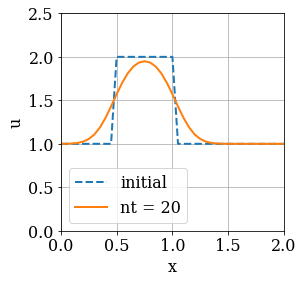

In [4]:
# Integrate in time.
u = u0.copy()
for n in range(nt):
    u[1:-1] = u[1:-1] + nu * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])

# Plot the solution after nt time steps
# along with the initial conditions.
pyplot.figure(figsize=(4.0, 4.0))
pyplot.xlabel('x')
pyplot.ylabel('u')
pyplot.grid()
pyplot.plot(x, u0, label='initial',
            color='C0', linestyle='--', linewidth=2)
pyplot.plot(x, u, label='nt = {}'.format(nt),
            color='C1', linestyle='-', linewidth=2)
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 2.5);

## Animations

Looking at before-and-after plots of the wave in motion is helpful, but it's even better if we can see it changing! 

First, let's import the `ipywidgets` module (more on this in a bit).

In [5]:
import ipywidgets

Now we will create an animation.  This takes a few steps, but it's actually not hard to do!
First, we define a function, called `diffusion`, that computes the numerical solution of the 1D diffusion equation and plots the solution.

In [6]:
def diffusion(nx, L=2.0, nu=0.3, sigma=0.5, nt=20):
    """
    Solves the 1D diffusion equation
    with constant viscosity in the domain [0, L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    L : float, optional
        Length of the domain; default: 2.0.
    nu : float, optional
        Viscosity; default: 0.3.
    sigma : float, optional
        CFL constraint; default: 0.5.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    # Discretize the spatial domain.
    dx = L / (nx - 1)  # spatial grid size
    x = numpy.linspace(0.0, L, num=nx)
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    # Compute the time-step size based on a CFL limit.
    dt = sigma * dx**2 / nu
    # Integrate the diffusion equation in time.
    u = u0.copy()
    for n in range(nt):
        u[1:-1] = u[1:-1] + nu * dt / dx**2 * (u[2:] - 2 * u[1:-1] + u[:-2])
    # Plot the solution along with the initial conditions.
    fig, ax = pyplot.subplots(figsize=(6.0, 6.0))
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.grid()
    ax.plot(x, u0, label='initial',
            color='C0', linestyle='--', linewidth=2)
    ax.plot(x, u, label='time step {}'.format(nt),
            color='C1', linestyle='-', linewidth=2)
    ax.legend()
    ax.set_xlim(0.0, L)
    ax.set_ylim(0.0, 2.5)
    pyplot.show()

Second, we create an interactive figure `w` with the `ipywidgets` module using the function `ipywidgets.interactive`.
Here, we create text boxes to enter the number of grid points (`nx`), the length of the domain (`L`), the viscosity (`nu`), and the CFL constraint (`CFL`).
We also create a slider for integers to control the time-step at which the solution should be computed (`time step`).
The widget `w` will call the function `diffusion` to compute and plot the solution based on the value of the parameters entered in the boxes and the position of the slider (defining the time-step index).

In [7]:
# Create text objects and integer slider for the parameters.
nx_value = ipywidgets.IntText(value=41, description='nx')
L_value = ipywidgets.FloatText(value=2.0, description='L')
nu_value = ipywidgets.FloatText(value=0.3, description='nu')
cfl_value = ipywidgets.FloatText(value=0.2, description='CFL')
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=20, step=1,
                                 description='time step')
# Create an interactive figure.
w = ipywidgets.interactive(diffusion,
                           nx=nx_value, L=L_value, nu=nu_value,
                           sigma=cfl_value, nt=nt_slider)
display(w)

interactive(children=(IntText(value=41, description='nx'), FloatText(value=2.0, description='L'), FloatText(va…

Now, you can easily interact with the figure, to investigate the effect of the parameters on the numerical solution. Sweet!

---

###### The cell below loads the style of the notebook.

In [8]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())